In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Set paths
RESULTS_DIR = "Results/Output/"
PROPENSITY_FILES = {
    "SAE_E2E": ["SAE_E2E_Prop_score_9.csv", "SAE_E2E_Prop_score_9_mmd.csv"],
    "SAE_stacked_all": ["SAE_stacked_all_Prop_score_9.csv", "SAE_stacked_all_Prop_score_9_mmd.csv"],
    "SAE_stacked_cur": ["SAE_stacked_cur_Prop_score_9.csv", "SAE_stacked_cur_Prop_score_9_mmd.csv"]
}


In [6]:
# Load propensity scores
def load_propensity_scores(files_dict, directory):
    dataframes = {}
    for model, files in files_dict.items():
        dataframes[model] = []
        for file in files:
            path = os.path.join(directory, file)
            if os.path.exists(path):
                df = pd.read_csv(path, index_col=0)  # Read file and ignore index column
                if df.shape[1] == 1:  # Ensure single-column structure
                    dataframes[model].append(df.iloc[:, 0])  # Extract scores column
                else:
                    print(f"Unexpected format in {file}")
            else:
                print(f"File not found: {path}")
    return dataframes

# Load the data
propensity_data = load_propensity_scores(PROPENSITY_FILES, RESULTS_DIR)

In [14]:
# Visualizing propensity scores
def plot_histogram(df1, df2, title):
    plt.figure(figsize=(8, 5))
    sns.histplot(df1, bins=50, kde=True, label="SAE", alpha=0.5)
    sns.histplot(df2, bins=50, kde=True, label="WAE_MMD", alpha=0.5)
    plt.legend()
    plt.title(f"Propensity Score Distribution: {title}")
    plt.xlabel("Propensity Score")
    plt.ylabel("Frequency")
    plt.show()

# Visualizing density plots
def plot_density(df1, df2, title):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df1, fill=True, alpha=0.5, label="SAE")
    sns.kdeplot(df2, fill=True, alpha=0.5, label="WAE_MMD")
    plt.legend()
    plt.title(f"Propensity Score Density: {title}")
    plt.xlabel("Propensity Score")
    plt.ylabel("Density")
    plt.show()

# Boxplot of propensity scores
def plot_boxplot(df1, df2, title):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=[df1, df2], notch=True)
    plt.xticks([0, 1], ["SAE", "WAE_MMD"])
    plt.title(f"Propensity Score Boxplot: {title}")
    plt.xlabel("Configurations")
    plt.ylabel("Propensity Score")
    plt.show()


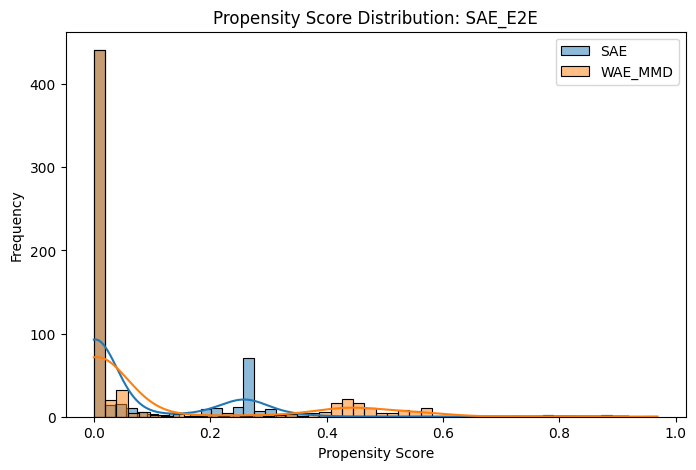

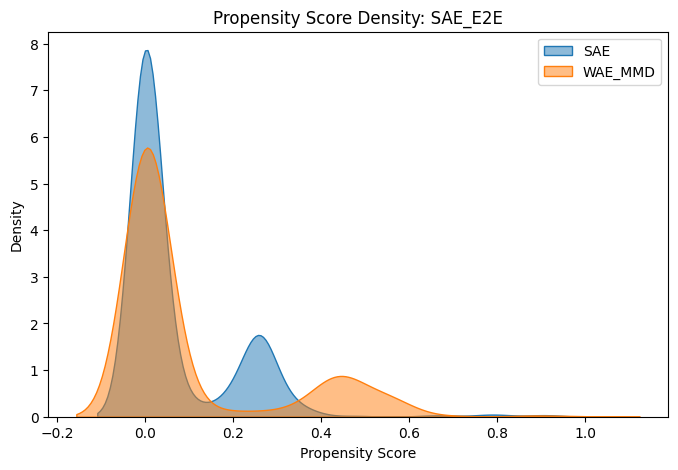

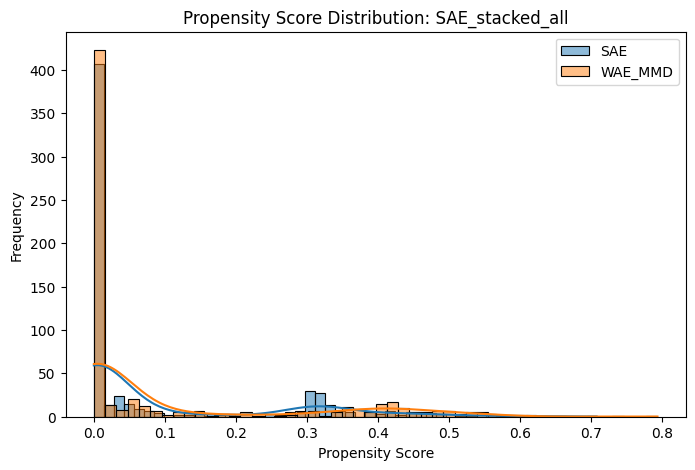

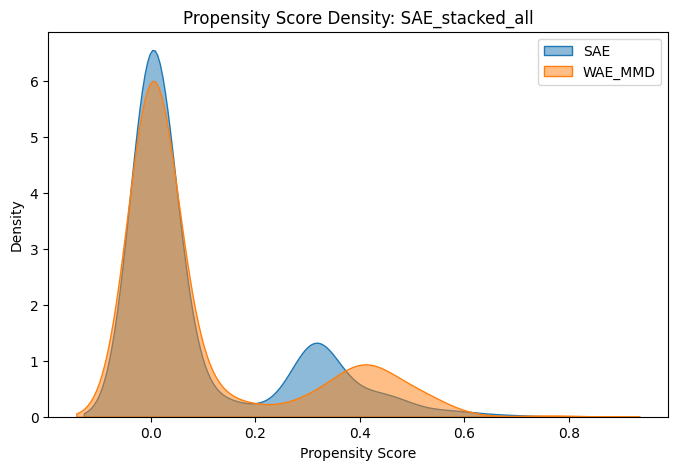

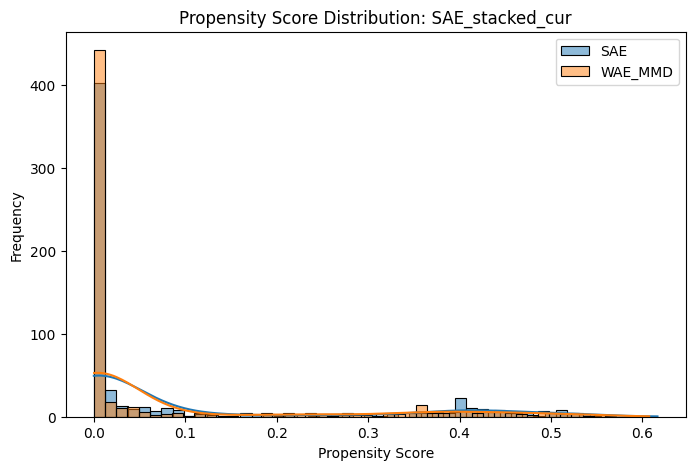

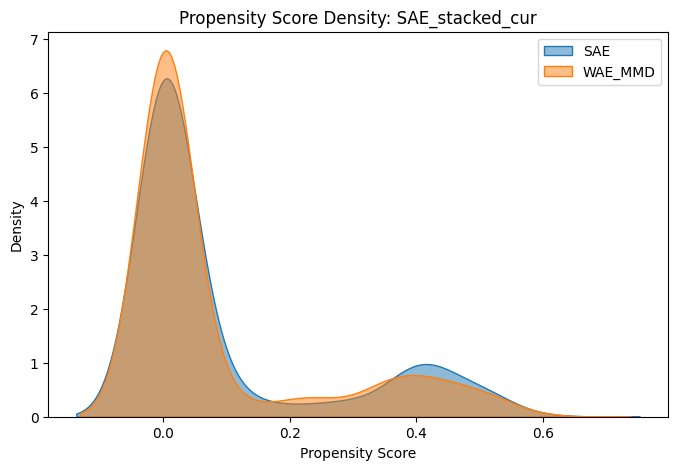

In [15]:
# Generate plots for each model
for model, dfs in propensity_data.items():
    if len(dfs) == 2:
        plot_histogram(dfs[0], dfs[1], model)
        plot_density(dfs[0], dfs[1], model)
        #plot_boxplot(dfs[0], dfs[1], model)

In [23]:
SAE_RESULTS_FILES = {
    "SAE_E2E": ["Results/Output/Results_consolidated.csv", "Results/Output/Results_consolidated_mmd.csv"],
    "SAE_stacked_all": ["Results/Output/Results_consolidated.csv", "Results/Output/Results_consolidated_mmd.csv"],
    "SAE_stacked_cur": ["Results/Output/Results_consolidated.csv", "Results/Output/Results_consolidated_mmd.csv"]
}

SAE_COLUMNS = {
    "SAE_E2E": ["SAE_e2e_ate_pred"],
    "SAE_stacked_all": ["SAE_stacked_all_layer_active_ate_pred"],
    "SAE_stacked_cur": ["SAE_stacked_cur_layer_active_ate_pred"]
}

In [29]:
# Load SAE results data
def load_sae_results(files_dict, columns_dict):
    sae_data = {}
    for model, files in files_dict.items():
        sae_data[model] = []
        for file in files:
            if os.path.exists(file):
                df = pd.read_csv(file, index_col=0)
                df_selected = df[columns_dict[model]] if all(col in df.columns for col in columns_dict[model]) else None
                if df_selected is not None:
                    config_name = "SAE" if "consolidated.csv" in file else "WAE_MMD"
                    df_selected = df_selected.rename(columns={columns_dict[model][0]: f"{model}_{config_name}"})
                    sae_data[model].append(df_selected)
                else:
                    print(f"Unexpected format in {file} for {model}")
            else:
                print(f"File not found: {file}")
    return sae_data

# Load the SAE data
sae_data = load_sae_results(SAE_RESULTS_FILES, SAE_COLUMNS)

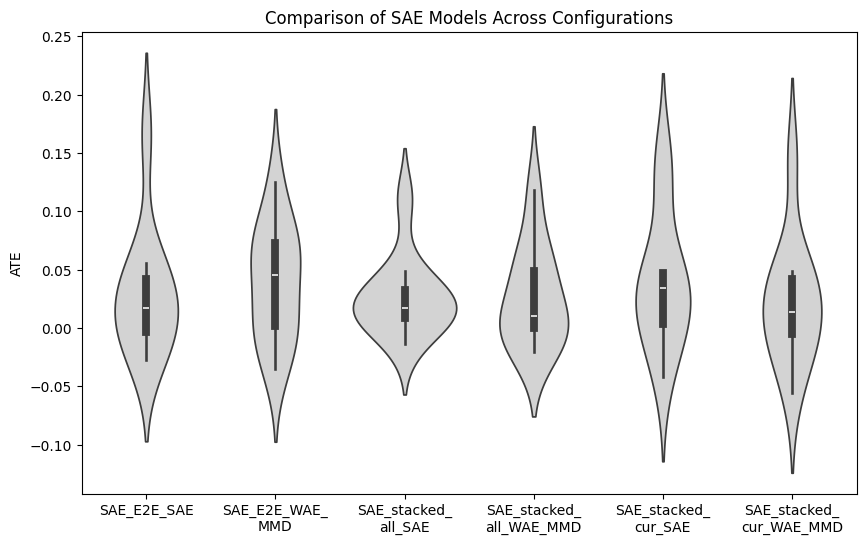

In [33]:
import textwrap

# Combined Violin Plot for All Models and Configurations
def plot_combined_violin(sae_data):
    plt.figure(figsize=(10, 6))
    data_to_plot = pd.concat([pd.concat(dfs, axis=1) for dfs in sae_data.values()], axis=1)
    
    sns.violinplot(data=data_to_plot, inner="box", color="#D3D3D3")  # Light grey color
    
    plt.title("Comparison of SAE Models Across Configurations")
    plt.ylabel("ATE")

    # Wrapping the x-tick labels to avoid rotation
    labels = [textwrap.fill(label, width=12) for label in data_to_plot.columns]
    plt.xticks(ticks=range(len(labels)), labels=labels, ha='center')

    plt.show()

# Generate combined violin plot
plot_combined_violin(sae_data)